In [1]:
import pandas as pd

df = pd.read_excel("Pharmaceutical Supply Chain Optimization.xlsx")
df.head()

,Drug,Demand_Forecast,Optimal_Stock_Level,Restocking_Strategy
0,Metformin,7750,4753,Monthly
1,Lisinopril,5136,9965,Quarterly
2,Metformin,3183,2933,Monthly
3,Insulin,2332,3927,Monthly
4,Atorvastatin,3522,6812,Monthly


In [2]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

for col in num_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    df[col] = df[col].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

df.head()

,Drug,Demand_Forecast,Optimal_Stock_Level,Restocking_Strategy
0,Metformin,7750,4753,Monthly
1,Lisinopril,5136,9965,Quarterly
2,Metformin,3183,2933,Monthly
3,Insulin,2332,3927,Monthly
4,Atorvastatin,3522,6812,Monthly


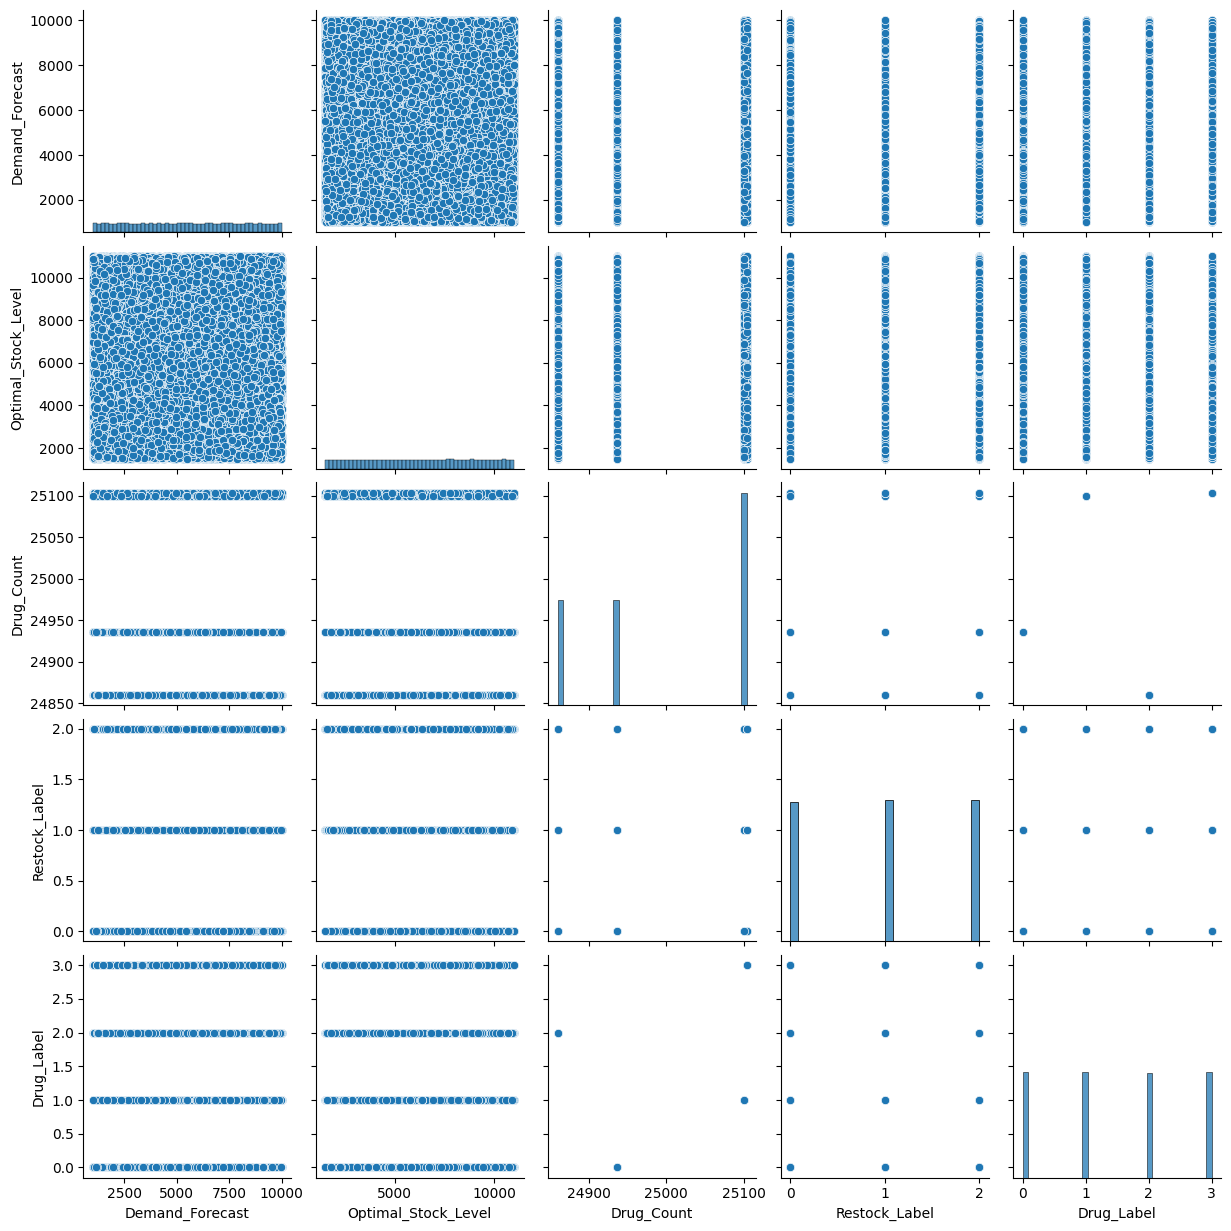

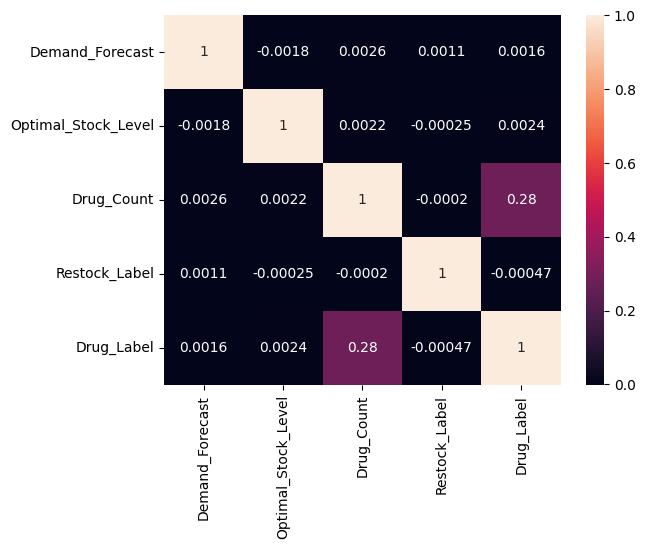

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df)
plt.show()

sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

In [4]:
df["Drug_Count"] = df["Drug"].map(df["Drug"].value_counts())
df["Restock_Label"] = df["Restocking_Strategy"].astype("category").cat.codes

df.head()

,Drug,Demand_Forecast,Optimal_Stock_Level,Restocking_Strategy,Drug_Count,Restock_Label
0,Metformin,7750,4753,Monthly,25104,0
1,Lisinopril,5136,9965,Quarterly,24860,1
2,Metformin,3183,2933,Monthly,25104,0
3,Insulin,2332,3927,Monthly,25100,0
4,Atorvastatin,3522,6812,Monthly,24936,0


In [5]:
df["Drug_Label"] = df["Drug"].astype("category").cat.codes

In [11]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [12]:
TARGET = "Optimal_Stock_Level"

X = df_encoded.drop(columns=[TARGET])
y = df_encoded[TARGET]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.metrics import mean_squared_error
import numpy as np

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_rmse = RMSE(y_test, lr_pred)
print("Linear Regression RMSE:", lr_rmse)

Linear Regression RMSE: 2738.2363596364944


In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_rmse = RMSE(y_test, rf_pred)
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 3163.305721097751


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

gb_rmse = RMSE(y_test, gb_pred)
print("Gradient Boosting RMSE:", gb_rmse)

Gradient Boosting RMSE: 2740.5174994326035


In [17]:
results = pd.DataFrame({
    "Model": ["LinearRegression", "RandomForest", "GradientBoosting"],
    "RMSE": [lr_rmse, rf_rmse, gb_rmse]
})

results

,Model,RMSE
0,LinearRegression,2738.236360
1,RandomForest,3163.305721
2,GradientBoosting,2740.517499


In [18]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

params = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10]
}

grid = GridSearchCV(rf, params, cv=3, scoring="neg_mean_squared_error")
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best RF params:", grid.best_params_)

Best RF params: {'max_depth': 10, 'n_estimators': 100}


In [19]:
pred = best_rf.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, pred))
print("Final RF RMSE:", final_rmse)

Final RF RMSE: 2741.402786938723
